In [16]:
library(openxlsx)
library(ggplot2)
library(tidyverse)
library(kernlab)
library(caret)
library(gridExtra)

In [17]:
method_file_name = "k_means"
#method_file_name = "random"
#method_file_name = "som"
#method_file_name = "kenndard_stone"
data_file_path = paste("data/",method_file_name,".xlsx",sep="")

train_df <- read.xlsx(data_file_path, sheet = 1) # training dataset
validation_df <- read.xlsx(data_file_path, sheet = 2) # validation dataset
test_df <- read.xlsx(data_file_path, sheet = 3) # testing dataset


#features names
features <- colnames(train_df)[-ncol(train_df)]
#labels
label <- colnames(train_df)[ncol(train_df)-1]
labelQ <- colnames(train_df)[ncol(train_df)]

#removing the duplicate column
train_df[label] <- NULL
validation_df[label] <- NULL
test_df[label] <- NULL
features <- c('SA/V','Th-SC','Th-Ep','Th-T','Fol-Den','Fol-Dia','Kow','ConAng','Kow-sw')
#features <- colnames(train_df)[-ncol(train_df)]
#changing the label character to factor
train_df[labelQ] <- as.factor(train_df[,labelQ])
validation_df[labelQ] <- as.factor(validation_df[,labelQ])
test_df[labelQ] <- as.factor(test_df[,labelQ])

#train_df <- unique(train_df)
#validation_df <- unique(validation_df)
#test_df <- unique(test_df)

head(train_df)
head(validation_df)
head(test_df)

Conc,SA,V,SA/V,Th-SC,Th-Ep,Th-T,Fol-Den,Fol-Dia,Enh,Kow,ConAng,Kow-sw,ConAng-sw,LayerQ
15.8547179,1256.637,4188.790,0.3000000,15.0,67.5,2.48,264.8,97,0,0.00,72,0,1,A
0.1268377,31415.927,523598.776,0.0600000,15.0,67.5,2.48,264.8,97,0,0.00,72,0,1,A
3.9636795,3298.672,41887.902,0.0787500,17.8,61.1,2.54,11.0,200,0,0.00,72,0,1,A
1.2737978,3769.911,15707.963,0.2400000,17.8,61.1,2.54,11.0,117,0,0.00,25,0,1,B
9.4000000,4300.840,26521.849,0.1621622,8.9,28.6,0.70,365.5,36,0,-1.16,0,1,0,B
18.0413267,2123.717,9202.772,0.2307692,17.8,61.1,2.54,11.0,117,0,0.00,139,0,1,B


Conc,SA,V,SA/V,Th-SC,Th-Ep,Th-T,Fol-Den,Fol-Dia,Enh,Kow,ConAng,Kow-sw,ConAng-sw,LayerQ
1.268377e-01,31415.92654,523598.77560,0.0600000,15.00000,67.50000,2.48000,264.8000,97,0,0.000,72,0,1,A
1.283477e-07,1256.63706,4188.79020,0.3000000,17.82125,61.10000,2.54742,11.0000,117,0,0.000,75,0,1,A
1.189104e+01,1256.63706,4188.79020,0.3000000,15.58889,67.54286,2.48000,264.8333,97,0,0.000,72,0,1,B
9.131662e-04,78.53982,65.44985,1.2000000,15.58889,67.54286,2.48000,264.8333,97,0,0.000,63,0,1,B
8.000000e-01,153.93804,179.59438,0.8571429,15.60000,67.50000,2.48000,264.8000,97,0,-0.075,0,1,0,B
8.067738e+00,3631.68111,20579.52628,0.1764706,17.80000,61.10000,2.54000,11.0000,117,0,0.000,90,0,1,B


Conc,SA,V,SA/V,Th-SC,Th-Ep,Th-T,Fol-Den,Fol-Dia,Enh,Kow,ConAng,Kow-sw,ConAng-sw,LayerQ
7.3957868,3848.4510,22449.29750,0.1714286,17.80000,61.10000,2.54,11.0000,200,0,0.00,72,0,1,A
33.5190452,706.8583,1767.14587,0.4000000,15.58889,67.54286,2.48,264.8333,97,0,0.00,151,0,1,B
10.0000000,4901.6699,32269.32709,0.1518987,17.82000,61.10000,2.54,11.0000,117,0,-1.16,0,1,0,B
1.0000000,66.4761,50.96501,1.3043478,16.60000,32.00000,2.09,289.0000,25,0,-1.16,0,1,0,B
2.5367549,7853.9816,65449.84695,0.1200000,17.80000,61.10000,2.54,11.0000,117,0,0.00,72,0,1,B
0.5661324,6126.1057,35342.91735,0.1733333,17.80000,61.10000,2.54,11.0000,117,0,0.00,25,0,1,B


In [18]:
train_valdiation_df <- rbind(train_df,validation_df)
pca_train <- prcomp(train_valdiation_df[,features],center = TRUE,  scale = TRUE, rank. = 8)
pca_trainX <- pca_train$x
trainY <- train_valdiation_df[,labelQ]

In [19]:
lpKSVM <- list(type = "Classification", library = "kernlab", loop = NULL)
lpKSVM$parameters <- data.frame(parameter = c("C","sigma"),
                     class = rep("numeric",2),
                     label = c("C","sigma"))

In [20]:
grid_tuning <- expand.grid(
  C =  0.16, #seq(28,30,1),
  sigma = 1.09 #seq(2.5,2.8,.05)
)
lpKSVM$grid = grid_tuning

In [21]:
lpKSVM$fit <- function(x, y, wts, param, lev, last, weights, classProbs, ...) { 
  kernlab::ksvm(
    x = as.matrix(x), y = y,
    kernel = "rbfdot",
    type = "kbb-svc",
    kpar = list(sigma = param$sigma),
    C = param$C,
    prob.model = classProbs,
    ...
  )
}

In [22]:
# predict function for CARET's custom model testing
lpKSVM$predict <- function(modelFit, newdata, preProc = NULL, submodels = NULL)
  kernlab::predict(modelFit, newdata)

lpKSVM$levels <- function(x) kernlab::lev(x)

lpKSVM$prob <- function(modelFit, newdata, preProc = NULL, submodels = NULL)
  kernlab::predict(modelFit, newdata, type = "probabilities")

In [23]:
# creating train control object
train_control <- caret::trainControl(
  method = "LOOCV", # leave one out cross validation
  verboseIter = TRUE,
  allowParallel = TRUE  
)

In [24]:
# searching for parameters
ksvm_base <- caret::train(
  x = pca_trainX,
  y = factor(trainY,labels = c("A","B","C","D","E")),
  trControl = train_control,
  tuneGrid = grid_tuning,
  method = lpKSVM,
  #index = 1:nrow(pca_trainX),
  #indexOut = nrow(pca_trainX)+(1:nrow(pca_validationX))
)

+ Fold001: C=0.16, sigma=1.09 
- Fold001: C=0.16, sigma=1.09 
+ Fold002: C=0.16, sigma=1.09 
- Fold002: C=0.16, sigma=1.09 
+ Fold003: C=0.16, sigma=1.09 
- Fold003: C=0.16, sigma=1.09 
+ Fold004: C=0.16, sigma=1.09 
- Fold004: C=0.16, sigma=1.09 
+ Fold005: C=0.16, sigma=1.09 
- Fold005: C=0.16, sigma=1.09 
+ Fold006: C=0.16, sigma=1.09 
- Fold006: C=0.16, sigma=1.09 
+ Fold007: C=0.16, sigma=1.09 
- Fold007: C=0.16, sigma=1.09 
+ Fold008: C=0.16, sigma=1.09 
- Fold008: C=0.16, sigma=1.09 
+ Fold009: C=0.16, sigma=1.09 
- Fold009: C=0.16, sigma=1.09 
+ Fold010: C=0.16, sigma=1.09 
- Fold010: C=0.16, sigma=1.09 
+ Fold011: C=0.16, sigma=1.09 
- Fold011: C=0.16, sigma=1.09 
+ Fold012: C=0.16, sigma=1.09 
- Fold012: C=0.16, sigma=1.09 
+ Fold013: C=0.16, sigma=1.09 
- Fold013: C=0.16, sigma=1.09 
+ Fold014: C=0.16, sigma=1.09 
- Fold014: C=0.16, sigma=1.09 
+ Fold015: C=0.16, sigma=1.09 
- Fold015: C=0.16, sigma=1.09 
+ Fold016: C=0.16, sigma=1.09 
- Fold016: C=0.16, sigma=1.09 
+ Fold01

Fitting final model on full training set


In [25]:
ksvm_model  <- ksvm(x = pca_trainX, y = trainY, type = "spoc-svc",C = ksvm_base$bestTune$C, kpar = list(sigma = ksvm_base$bestTune$sigma))
ksvm_base$bestTune$C
ksvm_base$bestTune$sigma

[1] 0.16

[1] 1.09

[1] "Checking the performance on the training set"
[1] 0.09090909


            predictions
observations  A  B  C  D  E
           A  2  2  1  0  0
           B  0 60  6  0  0
           C  0  2 64  0  0
           D  0  0  1  2  0
           E  0  1  0  0  2

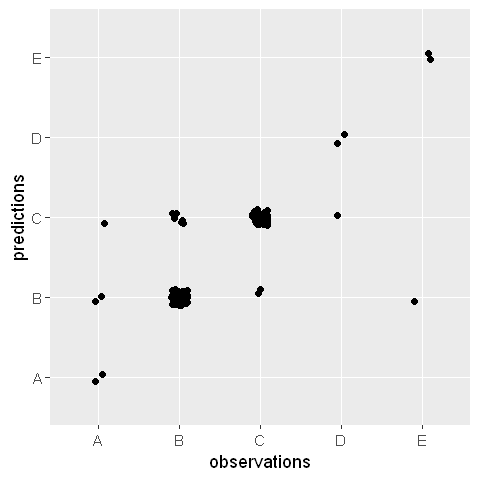

In [26]:
print("Checking the performance on the training set")
pred_labels <- predict(ksvm_model,pca_trainX)
print(sum(as.numeric(pred_labels) != (as.numeric(trainY)))/length(trainY))


options(repr.plot.width=4, repr.plot.height=4)
df.train = data.frame(observations = as.factor(trainY), predictions = as.factor(pred_labels) )
table(df.train)
plotTrainingSet <- ggplot(data = df.train,aes(x=observations,y=predictions)) + geom_jitter(width=0.1,height=0.1)
plotTrainingSet

In [27]:
confusionMatrix(data = df.train$observations, reference = df.train$predictions)

Confusion Matrix and Statistics

          Reference
Prediction  A  B  C  D  E
         A  2  2  1  0  0
         B  0 60  6  0  0
         C  0  2 64  0  0
         D  0  0  1  2  0
         E  0  1  0  0  2

Overall Statistics
                                          
               Accuracy : 0.9091          
                 95% CI : (0.8496, 0.9507)
    No Information Rate : 0.5035          
    P-Value [Acc > NIR] : < 2.2e-16       
                                          
                  Kappa : 0.8367          
                                          
 Mcnemar's Test P-Value : NA              

Statistics by Class:

                     Class: A Class: B Class: C Class: D Class: E
Sensitivity           1.00000   0.9231   0.8889  1.00000  1.00000
Specificity           0.97872   0.9231   0.9718  0.99291  0.99291
Pos Pred Value        0.40000   0.9091   0.9697  0.66667  0.66667
Neg Pred Value        1.00000   0.9351   0.8961  1.00000  1.00000
Prevalence            0.01399  

[1] "Checking the performance on the testing set"
[1] 0.125


            predictions
observations  A  B  C  D  E
           A  1  0  0  0  0
           B  0 14  2  0  0
           C  0  2 11  0  0
           D  0  0  0  1  0
           E  0  0  0  0  1

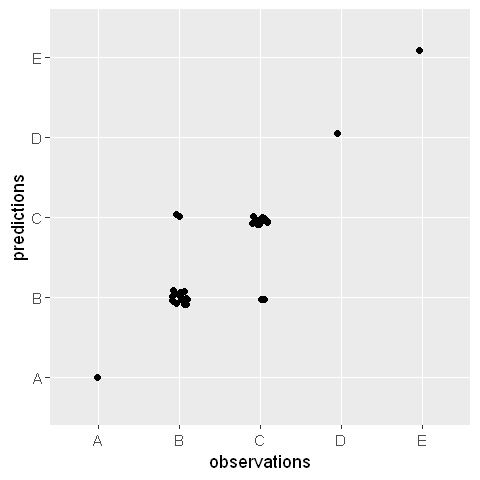

In [28]:
print("Checking the performance on the testing set")
testY = test_df[,labelQ]
pca_testX <- predict(pca_train,test_df)
pred_labels <- predict(ksvm_model,pca_testX)
print(sum(as.numeric(pred_labels) != (as.numeric(testY)))/length(testY))

df.test = data.frame(observations = as.factor(testY), predictions = (pred_labels) )
plotTestingSet <- ggplot(data = df.test,aes(x=observations,y=predictions)) + geom_jitter(width=0.1,height=0.1)
plotTestingSet
table(df.test)

In [29]:
confusionMatrix(data = df.test$observations, reference = df.test$predictions)

Confusion Matrix and Statistics

          Reference
Prediction  A  B  C  D  E
         A  1  0  0  0  0
         B  0 14  2  0  0
         C  0  2 11  0  0
         D  0  0  0  1  0
         E  0  0  0  0  1

Overall Statistics
                                          
               Accuracy : 0.875           
                 95% CI : (0.7101, 0.9649)
    No Information Rate : 0.5             
    P-Value [Acc > NIR] : 9.651e-06       
                                          
                  Kappa : 0.7852          
                                          
 Mcnemar's Test P-Value : NA              

Statistics by Class:

                     Class: A Class: B Class: C Class: D Class: E
Sensitivity           1.00000   0.8750   0.8462  1.00000  1.00000
Specificity           1.00000   0.8750   0.8947  1.00000  1.00000
Pos Pred Value        1.00000   0.8750   0.8462  1.00000  1.00000
Neg Pred Value        1.00000   0.8750   0.8947  1.00000  1.00000
Prevalence            0.03125  